# Kaggle: house prices
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## Import packages

In [352]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Stats
from scipy.stats.stats import skew
from scipy.stats.stats import pearsonr

## Import data

In [353]:
# Test and training set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Combine into one dataset for the purposes of cleaning, and make sure that index continues
data_full = pd.concat([train, test], keys = ['train', 'test'])#ignore_index = True)

In [354]:
# What does the dataset look like?
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Data cleansing

### Dealing with nulls

In [355]:
# Count the uniques for each column for a given dataframe
def df_uniques(df):
    print('Col name,', 'Number of nulls,', 'Number of unique values', '% of nulls')
    list_of_features = []
    for col in df:
        l = [col, df[col].shape[0] - df[col].count(), df[col].unique().shape[0], '%.3f' %((df[col].shape[0] - df[col].count()) / df[col].shape[0])]
        list_of_features.append(l)
    # Sort by the number of NULLs: 
    list_of_features = sorted(list_of_features, key = lambda x: x[1], reverse = True)
    return list_of_features

df_uniques(train)

Col name, Number of nulls, Number of unique values % of nulls


[['PoolQC', 1453, 4, '0.995'],
 ['MiscFeature', 1406, 5, '0.963'],
 ['Alley', 1369, 3, '0.938'],
 ['Fence', 1179, 5, '0.808'],
 ['FireplaceQu', 690, 6, '0.473'],
 ['LotFrontage', 259, 111, '0.177'],
 ['GarageType', 81, 7, '0.055'],
 ['GarageYrBlt', 81, 98, '0.055'],
 ['GarageFinish', 81, 4, '0.055'],
 ['GarageQual', 81, 6, '0.055'],
 ['GarageCond', 81, 6, '0.055'],
 ['BsmtExposure', 38, 5, '0.026'],
 ['BsmtFinType2', 38, 7, '0.026'],
 ['BsmtQual', 37, 5, '0.025'],
 ['BsmtCond', 37, 5, '0.025'],
 ['BsmtFinType1', 37, 7, '0.025'],
 ['MasVnrType', 8, 5, '0.005'],
 ['MasVnrArea', 8, 328, '0.005'],
 ['Electrical', 1, 6, '0.001'],
 ['Id', 0, 1460, '0.000'],
 ['MSSubClass', 0, 15, '0.000'],
 ['MSZoning', 0, 5, '0.000'],
 ['LotArea', 0, 1073, '0.000'],
 ['Street', 0, 2, '0.000'],
 ['LotShape', 0, 4, '0.000'],
 ['LandContour', 0, 4, '0.000'],
 ['Utilities', 0, 2, '0.000'],
 ['LotConfig', 0, 5, '0.000'],
 ['LandSlope', 0, 3, '0.000'],
 ['Neighborhood', 0, 25, '0.000'],
 ['Condition1', 0, 9, '0.0

In [356]:
# The following features have a crazy number of nulls 
# PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage 

# From looking at the data dictionary, these NAs are not necessarily a problem - but "NA" or nUll is misleading, so let's replace them
# Alley: NA = no alley -> replace with "None"
# MiscFeature: other features (e.g. tennis court) - NA = no other feature -> replace with "None"
# Fence: NA = no fence -> replace with "None"
# FireplaceQu: you guessed it -> replace with "None"

In [357]:
# Let's get a neat list of the null columns - need to combine both datasets for this
null_columns = [col for col in data_full.columns if data_full[col].isnull().any()]
print(null_columns)

['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType', 'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF', 'Utilities']


In [358]:
# Define a function to replace nulls for many columns: 
def fill_nulls(df, col_list, na_val):
    for col in col_list:
        df[col].fillna(value = na_val, inplace = True)
    return df

In [359]:
# Categorical fields with an obvious meaning NA -> 'None'
nulls_to_none = ['PoolQC', 'Fence', 'MiscFeature', 'Alley', 'FireplaceQu', 'MasVnrType', 'BsmtCond', 
                 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 
                 'GarageQual', 'GarageCond', 'KitchenQual']
# Numerical fields with an obvious meaning NA -> 0
nulls_to_zero = ['LotFrontage', 'MasVnrArea', 'BsmtQual', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 
                 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

# Categorical fields with a less obvious interpretation - guessing that NA means 'None' (there are very few anyway)
nulls_to_zero_2 = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd']
nulls_to_other = ['SaleType', 'Functional']

# Apply to both test and training sets:
for df in [train, test]: 
    fill_nulls(df, nulls_to_none, 'None')
    fill_nulls(df, nulls_to_zero, 0)
    fill_nulls(df, nulls_to_zero_2, 0)
    fill_nulls(df, nulls_to_other, 'Other')
# NB we still have 'data_full' which has not been updated yet

In [360]:
# Add more here about infilling with median values for some fields....

### Data types
Let's make sure everything is in the correct data type.  Pandas will have a go at importing things correctly, but this is good practice to make sure that things haven't gone awry. Ultimately we'll want to use dummy variables for categorical data anyway.

In [361]:
# Print out data types
def data_types(df):
    for col in df:
        print(col, type(df[col][1]))   

In [362]:
data_types(train)

Id <class 'numpy.int64'>
MSSubClass <class 'numpy.int64'>
MSZoning <class 'str'>
LotFrontage <class 'numpy.float64'>
LotArea <class 'numpy.int64'>
Street <class 'str'>
Alley <class 'str'>
LotShape <class 'str'>
LandContour <class 'str'>
Utilities <class 'str'>
LotConfig <class 'str'>
LandSlope <class 'str'>
Neighborhood <class 'str'>
Condition1 <class 'str'>
Condition2 <class 'str'>
BldgType <class 'str'>
HouseStyle <class 'str'>
OverallQual <class 'numpy.int64'>
OverallCond <class 'numpy.int64'>
YearBuilt <class 'numpy.int64'>
YearRemodAdd <class 'numpy.int64'>
RoofStyle <class 'str'>
RoofMatl <class 'str'>
Exterior1st <class 'str'>
Exterior2nd <class 'str'>
MasVnrType <class 'str'>
MasVnrArea <class 'numpy.float64'>
ExterQual <class 'str'>
ExterCond <class 'str'>
Foundation <class 'str'>
BsmtQual <class 'str'>
BsmtCond <class 'str'>
BsmtExposure <class 'str'>
BsmtFinType1 <class 'str'>
BsmtFinSF1 <class 'numpy.int64'>
BsmtFinType2 <class 'str'>
BsmtFinSF2 <class 'numpy.int64'>
BsmtUn

In [363]:
# By pasting the above list into a spreadsheet and cross checking with the data dictionary, we can 
# see which category each field should be

# statsmodel requires all fieldsnames to begin with letters, so let's sort this out now.
train = train.rename(columns = {'1stFlrSF': 'FirstFlrSF','2ndFlrSF': 'SecondFlrSF','3SsnPorch': 'ThreeSsnPorch'})
test = test.rename(columns = {'1stFlrSF': 'FirstFlrSF','2ndFlrSF': 'SecondFlrSF','3SsnPorch': 'ThreeSsnPorch'})
data_full = pd.concat([train, test], keys = ['train', 'test'])

# Makes lists of each type
categories = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
              'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 
              'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 
              'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'Heating', 
              'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 
              'GarageFinish', 'GarageCars', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 
              'SaleCondition']
floats = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
          'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
          'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

ints = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
         'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']

bools = ['CentralAir']

feature_names = categories + floats + ints + bools

# Define a function for converting a list of columns to a particular type: 
def convert_col_type(df, cols, type):
    for col in cols:
        df[col] = df[col].astype(type)

In [364]:
# Convert each column for both test and training sets:
for df in [train, test]:
    convert_col_type(df, categories, 'category')
    convert_col_type(df, floats, 'float')
    convert_col_type(df, ints, 'int')
    convert_col_type(df, bools, 'bool')
    
# Re-define the full dataset
data_full = pd.concat([train, test], keys = ['train', 'test'])

In [365]:
# Print out data types
def data_types(df):
    for col in df:
        print(col, type(df[col][1]))   
data_types(train)

Id <class 'numpy.int64'>
MSSubClass <class 'numpy.int64'>
MSZoning <class 'str'>
LotFrontage <class 'numpy.float64'>
LotArea <class 'numpy.float64'>
Street <class 'str'>
Alley <class 'str'>
LotShape <class 'str'>
LandContour <class 'str'>
Utilities <class 'str'>
LotConfig <class 'str'>
LandSlope <class 'str'>
Neighborhood <class 'str'>
Condition1 <class 'str'>
Condition2 <class 'str'>
BldgType <class 'str'>
HouseStyle <class 'str'>
OverallQual <class 'numpy.int64'>
OverallCond <class 'numpy.int64'>
YearBuilt <class 'numpy.int64'>
YearRemodAdd <class 'numpy.int64'>
RoofStyle <class 'str'>
RoofMatl <class 'str'>
Exterior1st <class 'str'>
Exterior2nd <class 'str'>
MasVnrType <class 'str'>
MasVnrArea <class 'numpy.float64'>
ExterQual <class 'str'>
ExterCond <class 'str'>
Foundation <class 'str'>
BsmtQual <class 'str'>
BsmtCond <class 'str'>
BsmtExposure <class 'str'>
BsmtFinType1 <class 'str'>
BsmtFinSF1 <class 'numpy.float64'>
BsmtFinType2 <class 'str'>
BsmtFinSF2 <class 'numpy.float64'>


## Motivating plots

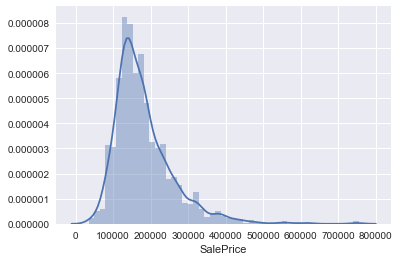

In [366]:
sales_price = train['SalePrice']
graph = sns.distplot(sales_price)

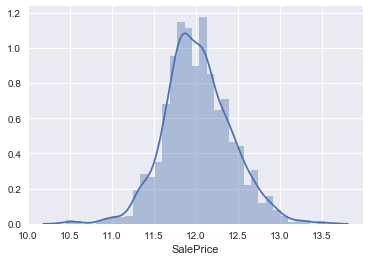

In [367]:
# Let's log-tranform this: 
sales_prices_log = np.log1p(sales_price)
graph = sns.distplot(sales_prices_log)

In [368]:
# This looks much better, so let's replace the SalePrice with the log-transformed version (will need to exponentiate predictions)
train['SalePrice'] = np.log1p(train['SalePrice'])

In [369]:
# Re-define the full dataset - and work on this until we are ready to split out test and train sets again
data_full = pd.concat([train, test], keys = ['train', 'test'])

In [370]:
# Let's see if any other features are skewed and replace these with log-transformed versions if so  
skewed_features = data_full[floats].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features

LotArea          12.822431
MasVnrArea        2.613592
BsmtFinSF1        1.425230
BsmtFinSF2        4.146143
BsmtUnfSF         0.919339
TotalBsmtSF       1.156894
FirstFlrSF        1.469604
SecondFlrSF       0.861675
LowQualFinSF     12.088761
GrLivArea         1.269358
WoodDeckSF        1.842433
OpenPorchSF       2.535114
EnclosedPorch     4.003891
ThreeSsnPorch    11.376065
ScreenPorch       3.946694
PoolArea         16.898328
MiscVal          21.947195
dtype: float64

In [371]:
skewed_features = skewed_features.index

In [372]:
#data_full[skewed_features] = np.log1p(data_full[skewed_features])
for col in skewed_features:
   data_full[col] = np.log1p(data_full[col])

## Standardising numeric features

In [373]:
# Standardise numeric features (normalise)
numeric_features = data_full.loc[:,floats]
numeric_features_st = (numeric_features - numeric_features.mean())/numeric_features.std()

In [374]:
data_full.loc[:,floats] = numeric_features_st

In [375]:
#ax = sns.pairplot(numeric_features_st)
# ax.savefig('charts_complete.png')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [376]:
# Too many variables!  

### Split test-train sets again

In [377]:
# First, create dummy variables for categorical variables
dummy = pd.get_dummies(train)
# split out the test and train sets again
train = data_full.ix['train']
test = data_full.ix['test']

## Linear regression, backward elimination

In [422]:
# For the purposes of a multiple regression, let's use statsmodel rather than scikit learn, as it gives us
# more information, such as p-values, and hence, which regressors are important.
import statsmodels.formula.api as smf

# create a fitted model with the features that are floats: 
#lm = smf.ols(formula='SalePrice ~ LotFrontage + LotArea + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + GarageArea + WoodDeckSF + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea + MiscVal + OverallQual + OverallCond + BsmtFullBath + BsmtHalfBath + FullBath + BedroomAbvGr + KitchenAbvGr + TotRmsAbvGrd + Fireplaces', data=train).fit()
formula = 'SalePrice ~ ' + ' + '.join(feature_names)
lm = smf.ols(formula=formula, data=train).fit()

# print the coefficients
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     69.19
Date:                Fri, 28 Apr 2017   Prob (F-statistic):               0.00
Time:                        12:55:44   Log-Likelihood:                 1440.4
No. Observations:                1460   AIC:                            -2261.
Df Residuals:                    1150   BIC:                            -622.1
Df Model:                         309                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.9953      1.835     -0.542      0.588      -4.595       2.605
Alley[T.None]               -0.0026      0.019     -0.135      0.892      -0.040       0.035
Alley[T.Pave]                0.0287      0.028      1.041      0.298      -0.025       0.083
BldgType[T.2fmCon]           0.0189      0.059      0.320      0.749      -0.097       0.135
BldgType[T.Duplex]          -0.0172      0.035     -0.492      0.623      -0.086       0.051
BldgType[T.Twnhs]           -0.0067      0.047     -0.143      0.887      -0.099       0.085
BldgType[T.TwnhsE]           0.0066      0.042      0.156      0.876      -0.076       0.090
BsmtCond[T.Gd]               0.0330      0.025      1.341      0.180      -0.015       0.081
BsmtCond[T.None]             0.2331      0.404      0.577      0.564      -0.560       1.026
BsmtCond[T.Po]               0.1275      0.131      0.971      0.332      -0.130       0.385
BsmtCond[T.TA]               0.0390      0.019      2.036      0.042       0.001       0.077
BsmtExposure[T.Gd]           0.0420      0.014      3.066      0.002       0.015       0.069
BsmtExposure[T.Mn]          -0.0032      0.014     -0.226      0.821      -0.031       0.024
BsmtExposure[T.No]          -0.0084      0.010     -0.822      0.411      -0.029       0.012
BsmtExposure[T.None]        -0.0829      0.106     -0.785      0.433      -0.290       0.124
BsmtFinType2[T.BLQ]         -0.0443      0.035     -1.285      0.199      -0.112       0.023
BsmtFinType2[T.GLQ]         -0.0083      0.043     -0.196      0.845      -0.092       0.075
BsmtFinType2[T.LwQ]         -0.0177      0.033     -0.532      0.595      -0.083       0.047
BsmtFinType2[T.None]         0.0249      0.110      0.227      0.821      -0.191       0.241
BsmtFinType2[T.Rec]         -0.0215      0.032     -0.676      0.499      -0.084       0.041
BsmtFinType2[T.Unf]         -0.0345      0.079     -0.435      0.664      -0.190       0.121
BsmtQual[T.Ex]              -0.2807      0.373     -0.753      0.451      -1.012       0.450
BsmtQual[T.Fa]              -0.3060      0.369     -0.829      0.407      -1.030       0.418
BsmtQual[T.Gd]              -0.3207      0.371     -0.863      0.388      -1.050       0.408
BsmtQual[T.TA]              -0.3210      0.370     -0.868      0.386      -1.047       0.405
CentralAir[T.True]          -0.9953      1.835     -0.542      0.588      -4.595       2.605
Condition1[T.Feedr]          0.0452      0.023      1.970      0.049       0.000       0.090
Condition1[T.Norm]           0.0849      0.019      4.451      0.000       0.047       0.122
Condition1[T.PosA]           0.0433      0.046      0.935      0.350      -0.048       0.134
Condition1[T.PosN]           0.0795      0.034      2.330      0.020       0.013       0.146
Condition1[T.R

In [424]:
# Best features
lm.pvalues.sort_values(ascending = False, inplace=False).tail(10)

RoofMatl[T.CompShg]    6.967884e-10
RoofMatl[T.WdShngl]    1.341959e-11
MSZoning[T.RH]         1.480249e-14
LotArea                1.069747e-14
OverallQual            1.619649e-16
GrLivArea              1.562610e-16
MSZoning[T.FV]         7.284718e-17
MSZoning[T.RL]         2.286502e-19
MSZoning[T.RM]         6.723468e-20
OverallCond            1.042408e-24
dtype: float64

In [423]:
# Worst features
lm.pvalues.sort_values(ascending = False, inplace=False).head(10)

Exterior1st[T.AsphShn]    0.988487
YearRemodAdd[T.1964]      0.981331
Exterior2nd[T.Plywood]    0.980372
Exterior2nd[T.Wd Shng]    0.977325
YearRemodAdd[T.1957]      0.974978
MasVnrArea                0.965292
HouseStyle[T.2.5Fin]      0.960406
Exterior2nd[T.HdBoard]    0.953849
Condition2[T.RRNn]        0.945483
YearRemodAdd[T.1969]      0.940640
dtype: float64

It looks like the most important predictors relate to the type of roofing material (perhaps correlated with certain neighbourhoods, or architecture styles, that are in turn correlated with demographic factors), and features related to the size of the house (LotArea, GrLivArea, OverallQual).  This intuitively makes sense.  

On the other hand, features that are fairly useless relate to remodelling of the house, and exterior surface features.

Since there are so many features, it would make sense to either remove these via principal component analysis, or perform a regularisation to penalise the extra features.  This avoids over-fitting.  In particular, lasso regularisation performs some feature selection for us.

## Collinearity
Let's also check to see which predictors are correlated; there are many features that essentially encode the same information in different way.

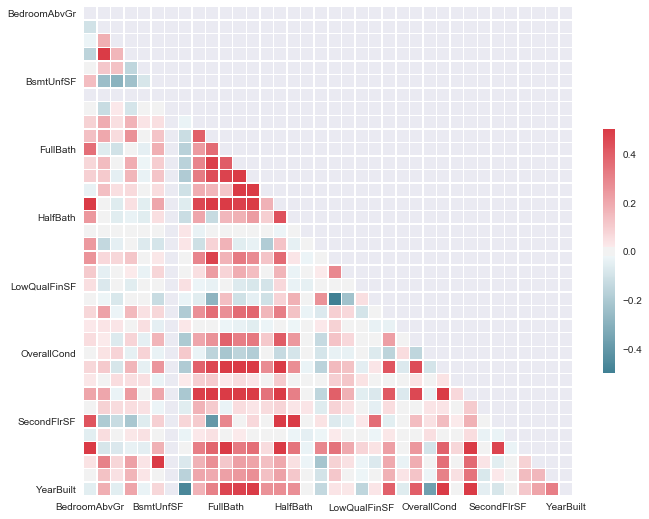

In [382]:
# Compute the correlation matrix
corr = data_full.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Simpler version (but too small to be useful)
# plt.matshow(data_full.corr())

Several predictors seem to be correlated, but the maximum correlation appears to be 0.4, so it's not worth removing these.

## Splitting the testing and training sets again; define dummy variables for categories

In [428]:
# Features - remove the thing we're trying to predict!
features = data_full.drop('SalePrice', axis = 1)

# Create dummy variables - for each categorical data, make several boolean flags
features = pd.get_dummies(features)

# Make matrices to pass to scikit learn:
X_train = features[:train.shape[0]]
X_test = features[train.shape[0]:]
y = train['SalePrice']

# Verify that the number of features has been increased due to the dummy variables:
print('Number of features in original dataset, including categorical fields: ', train.shape[1], 
      '\nNumber of features, including dummy variables for categorical fields: ', X_train.shape[1])

Number of features in original dataset, including categorical fields:  81 
Number of features, including dummy variables for categorical fields:  385


## Ridge regularisation (L2 regularisation)

In [384]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
#from sklearn.metrics import mean_squared_error

In [385]:
# Define root-mean-square-error function - use 10-fold cross-validation
# You have to use neg_mean_squared_error because mean_squared_error will be deprecated in future
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return rmse

# Invoke Ridge regularisation
model_ridge = Ridge()

In [386]:
# Tune parameters - the only parameter is alpha - the larger alpha, the larger the penalty for extra predictors
alphas = [0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# Work out the RMSE for each value of the alphas above: 
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)

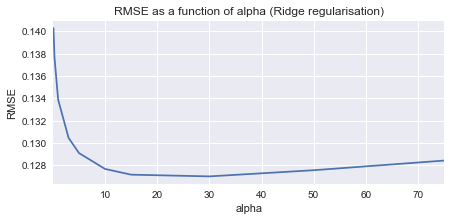

In [387]:
# Let's plot the RMSE as a function of alpha
matplotlib.rcParams['figure.figsize'] = (7,3)
cv_ridge.plot(title = 'RMSE as a function of alpha (Ridge regularisation)')
plt.xlabel('alpha')
plt.ylabel('RMSE')

We want to chose the value of $\alpha$ that minimises the chart above. The extreme cases are $\alpha = 0$, which corresponds to no penalty for each extra predictor, and $\alpha\to\inf$ which corresponds to a null model.  We want a balance between flexibility and over-fitting, which represents the minimium of this chart.

In [429]:
cv_ridge.min()

0.12700475231309477

In [450]:
# This looks like it correpsonds to alpha = 30, so let's fit the model with that.
model_ridge = Ridge(alpha = 30)
model_ridge.fit(X_train, y)

Ridge(alpha=30, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

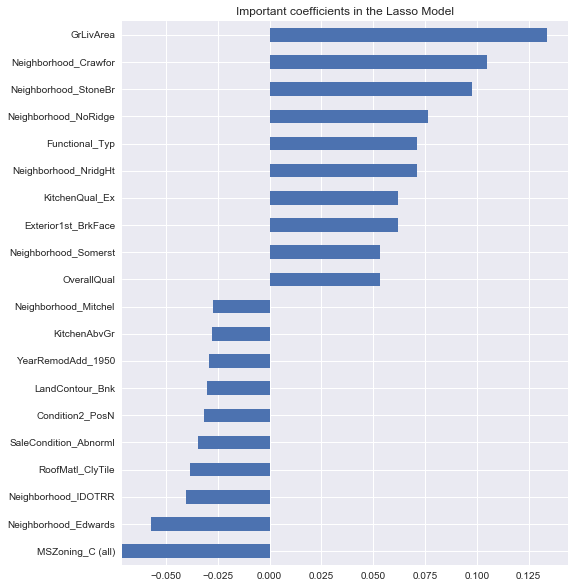

In [490]:
# What are the important coefficients here?
coef_ridge = pd.Series(model_ridge.coef_, index = X_train.columns)
important_coef_ridge = pd.concat([coef_ridge.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef_ridge.plot(kind = "barh")
plt.title('Important coefficients in the Lasso Model')

In [492]:
# How many features were eliminated? 
print("Ridge picked " + str(sum(coef_ridge != 0)) + " features and eliminated the other " + str(sum(coef_ridge == 0)) + " features")

Ridge picked 377 features and eliminated the other 8 features


In [451]:
#let's look at the residuals as well:
def plot_residuals(model, X_train, y):
    matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
    preds = pd.DataFrame({"preds":model.predict(X_train), "true":y})
    preds["residuals"] = preds["true"] - preds["preds"]
    preds.plot(x = "preds", y = "residuals",kind = "scatter")

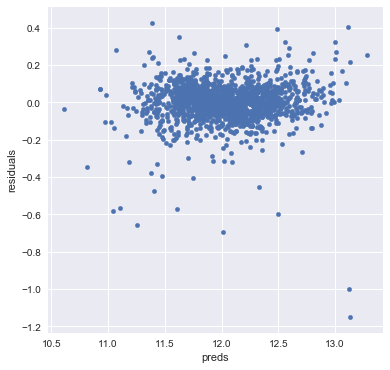

In [453]:
plot_residuals(model_ridge, X_train, y)

These look pretty good - nicely clustered around 0.

## Lasso regularisation (L1 regularisation)
The advantage of Lasso regularisation is that it performs some feature selection.  We'll use Lasso cross-validation to choose the $\alpha$ for us.

In [487]:
model_lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
                     max_iter = 50000, cv = 10).fit(X_train, y)
# Coefficients of each predictor:
coef_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

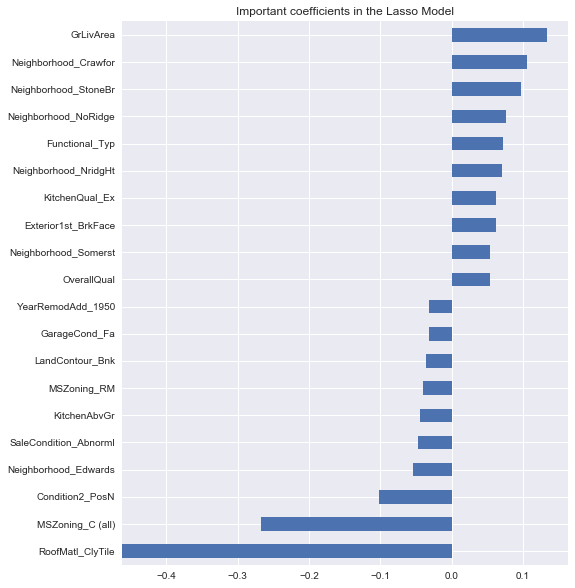

In [488]:
# What are the important coefficients here?
important_coef_lasso = pd.concat([coef_lasso.sort_values().head(10), coef_lasso.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef_lasso.plot(kind = "barh")
plt.title('Important coefficients in the Lasso Model')

A lot of these are on the list of features picked out by the normal multiple regression without regularisation. Not the hugely negative coefficient for Clay Tile - there is only one house with this feature, so this is not actually a particuarly important feature.

In [461]:
data_full['RoofMatl'].value_counts()

CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Roll          1
Membran       1
ClyTile       1
Metal         1
Name: RoofMatl, dtype: int64

In [462]:
data_full[data_full['RoofMatl'] == 'ClyTile']['SalePrice']

train  1298    11.982935
Name: SalePrice, dtype: float64

In [515]:
# How many features were eliminated? 
print("Lasso picked " + str(sum(coef != 0)) + " features and eliminated the other " + str(sum(coef == 0)) + " features")

Lasso picked 106 features and eliminated the other 279 features


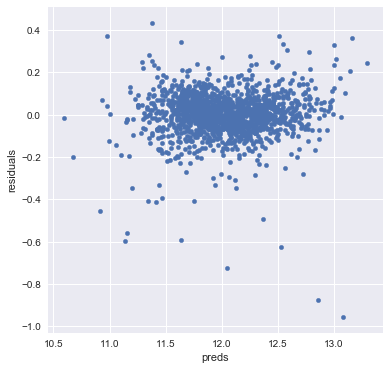

In [457]:
# Let's have a look at the residuals of this too.    
plot_residuals(model_lasso, X_train, y)

## Elastic net regularisation


In [494]:
from sklearn.linear_model import ElasticNetCV

In [511]:
model_elastic = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
model_elastic.fit(X_train, y)
alpha = model_elastic.alpha_
ratio = model_elastic.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

Best l1_ratio : 0.7
Best alpha : 0.0006


In [517]:
# How many features were eliminated? 
print("Elastic picked " + str(sum(coef_elastic != 0)) + " features and eliminated the other " + str(sum(coef_elastic == 0)) + " features")

Elastic picked 133 features and eliminated the other 252 features


In [513]:
coef_elastic = pd.Series(model_elastic.coef_, index = X_train.columns)

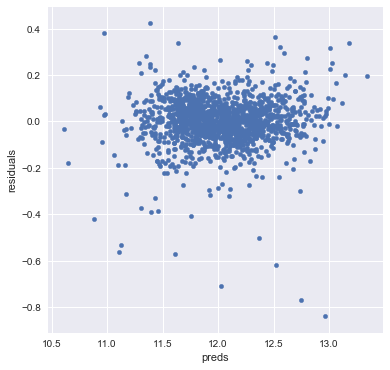

In [514]:
plot_residuals(model_elastic, X_train, y)

These look almost identical to the residuals for the Lasso, and the number of features is larger, so it's probalby more prone to over-fitting.  I'm sticking with the Lasso regularisation.

# Make predictions

In [533]:
ridge_preds = np.expm1(model_ridge.predict(X_train))
lasso_preds = np.expm1(model_lasso.predict(X_train))
elastic_preds = np.expm1(model_elastic.predict(X_train))

1459

In [532]:
kaggle_export = pd.DataFrame({
    'id': test['Id'],
    'SalePrice': lasso_preds
},
columns = ['id', 'SalePrice'])

ValueError: array length 1460 does not match index length 1459

In [528]:
def make_export_table(preds):
    kaggle_export = pd.DataFrame({
        'id': test['Id'],
        'SalePrice': preds
    },
    columns = ['id', 'SalePrice'])
    return kaggle_export

In [530]:
#make_export_table(elastic_preds)
len(elastic_preds)

1460

In [396]:
# Export with timestamp in filename so we can save results from different runs


In [520]:
for model in ['ridge', 'lasso', 'elastic']:
    filebasename = 'kaggle_export'
    timestamp = datetime.today().strftime('%Y%m%d-%H%M%S')
    filename = filebasename + timestamp + model
    kaggle_export.to_csv(filename, index = False)